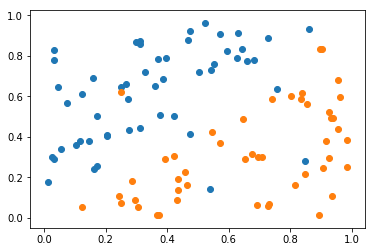

In [3]:
import numpy as np
import matplotlib.pyplot as plt

#读取数据并作图
train = np.genfromtxt('hw7_train.dat')
X_train, y_train = train[:, :-1], train[:, -1]
test = np.genfromtxt('hw7_test.dat')
X_test, y_test = test[:, :-1], test[:, -1]

#作图
plt.scatter(train[:, 0][train[:, 2] == -1], train[:, 1][train[:, 2] == -1])
plt.scatter(train[:, 0][train[:, 2] == 1], train[:, 1][train[:, 2] == 1])
plt.show()

In [31]:
#Gini index
def Gini(y):
    '''
    二分类gini系数
    '''
    if(len(y) == 0):
        return 1
    t = np.mean(y == -1)
    return 1 - t**2 - (1 - t)**2

#定义impurty
def lossfunc(theta, X, y):
    '''
    d为数据的维度，theta为decision stump的阈值
    '''
    y1 = y[X < theta]
    y2 = y[X >= theta]
    Gini1 = Gini(y1)
    Gini2 = Gini(y2)
    return len(y1) * Gini1 + len(y2) * Gini2

def Generate_theta(X):
    """
    生成阈值
    """
    X = np.sort(X)
    theta = (X[1:] + X[:-1]) / 2
    theta = np.r_[[X[0] - 1], theta]
    theta = np.r_[theta, [X[-1] + 1]]
    
    return theta

#在d个维度上分别利用decision stump计算，找到损失函数的最小值，返回维度以及阈值
def Decision_stump(X, y):
    """
    对d个维度使用Decision_stump
    """
    #获得数据维度
    n, d = X.shape
    #最终结果
    Theta = 0
    D = 0
    Score = n
    for i in range(d):
        #取第d维的数据
        x = X[:, i]
        #计算阈值
        theta = Generate_theta(x)
        #遍历
        for theta_ in theta:
            #计算损失函数
            score = lossfunc(theta_, x, y)
            if score < Score:
                Score = score
                Theta = theta_
                D = i
    
    return D, Theta, Score

def isstop(X, y):
    '''
    判断是否停止，有两种情形，X全相同，另一种是所有数据都为一类
    '''
    n = X.shape[0]
    #n1 = np.sum(y==-1)
    n1 = np.sum(y!=y[0])
    n2 = np.sum(X!=X[0, :])
    return n1 == 0 or n2 == 0

#构造树类
class DTree:
    def __init__(self, theta, d, value=None):
        #阈值
        self.theta = theta
        #维度
        self.d = d
        #当前节点对应的值
        self.value = value
        #左右节点
        self.left = None
        self.right = None

NUM = 0
#构造学习函数
def learntree(X, y):
    global NUM
    NUM += 1
    if isstop(X, y):
        #print(X.shape, y)
        return DTree(None, None, y[0])
    else:
        d, theta, score = Decision_stump(X, y)
        #print(d, theta, score)
        tree = DTree(theta, d)
        #划分数据
        i1 = X[:, d] < theta
        X1 = X[i1]
        #print("X1", X1.shape)
        y1 = y[i1]
        i2 = X[:, d] >= theta
        X2 = X[i2]
        y2 = y[i2]
        #学习左树
        leftTree = learntree(X1, y1)
        #学习右树
        rightTree = learntree(X2, y2)
        #返回
        tree.left = leftTree
        tree.right = rightTree
        
        return tree
    
#预测函数
def pred(tree, x):
    #if tree.left == None and tree.right == None:
    if tree.value != None:
        return tree.value
    if x[tree.d] < tree.theta:
        return pred(tree.left, x)
    else:
        return pred(tree.right, x)
    

#计算误差
def error(tree, X, y):
    ypred = [pred(tree, x) for x in X]
    return np.mean(ypred!=y)

dtree = learntree(X_train, y_train)

In [32]:
#14
print(error(dtree, X_train, y_train))

0.0


In [33]:
#15
print(error(dtree, X_test, y_test))

0.126


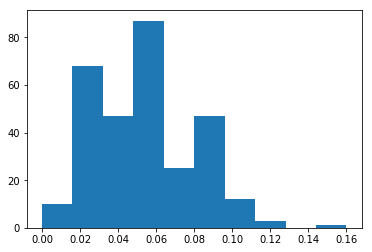

In [35]:
#16
N = 300
Ein = np.array([])
tree = []
m, n = train.shape
for i in range(N):
    index = np.random.randint(0, m, (m))
    X1 = X_train[index, :]
    y1 = y_train[index]
    dtree = learntree(X1, y1)
    tree.append(dtree)
    Ein = np.append(Ein, error(dtree, X_train, y_train))
    
plt.hist(Ein)
plt.show()

In [37]:
print("Ein = {}".format(np.mean(Ein)))

Ein = 0.05319999999999999


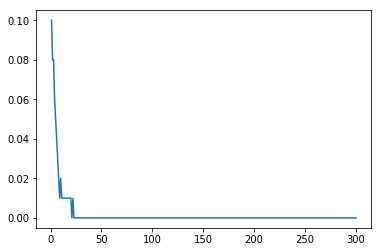

In [38]:
#17
def random_forest_error(tree, X, y):
    """
    利用前k个树计算结果
    """
    Error = np.array([])
    N = len(tree)
    for i in range(N):
        E = []
        for j in range(1+i):
            E.append([pred(tree[j], x) for x in X])
        E = np.array(E)
        #0视为1
        ypred = np.sign(E.sum(axis=0) + 0.5)
        error = np.mean(ypred!=y)
        Error = np.append(Error, error)
    return Error

Ein_G = random_forest_error(tree, X_train, y_train)

plt.plot(np.arange(1, N+1), Ein_G)
plt.show()

In [40]:
print("Ein = {}".format(np.mean(Ein_G)))

Ein = 0.002


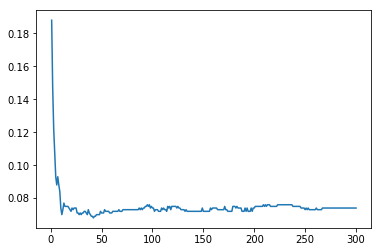

In [41]:
#18
Eout_G = random_forest_error(tree, X_test, y_test)

plt.plot(np.arange(1, N+1), Eout_G)
plt.show()

In [42]:
print("Eout = {}".format(np.mean(Eout_G)))

Eout = 0.07453666666666665


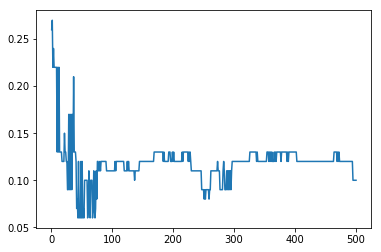

In [45]:
#19
def learntree_new(X, y):
    d, theta, score = Decision_stump(X, y)
    tree = DTree(theta, d)
    #划分数据
    i1 = X[:, d] < theta
    X1 = X[i1]
    y1 = y[i1]
    i2 = X[:, d] >= theta
    X2 = X[i2]
    y2 = y[i2]
    #学习左树
    leftTree = learntree(X1, y1)
    #学习右树
    rightTree = learntree(X2, y2)
    
    #左树
    k1 = np.sign(np.sum(y1) + 0.5)#+0.5是为了防止出现0
    leftTree = DTree(None, None, k1)
    #右树
    k2 = np.sign(np.sum(y2) + 0.5)
    rightTree = DTree(None, None, k2)
    #返回
    tree.left = leftTree
    tree.right = rightTree
    return tree

N = 500
newtree = []
m, n = train.shape
for i in range(N):
    index = np.random.randint(0, m, (m))
    X1 = X_train[index, :]
    y1 = y_train[index]
    dtree = learntree_new(X1, y1)
    newtree.append(dtree)
    
newEin_G = random_forest_error(newtree, X_train, y_train)

plt.plot(np.arange(1, N+1), newEin_G)
plt.show()

In [46]:
print("Ein = {}".format(np.mean(newEin_G)))

Ein = 0.11872000000000002


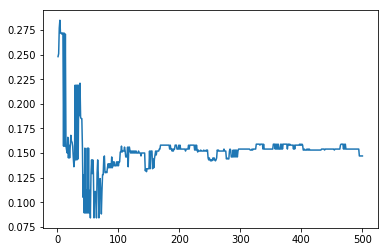

In [51]:
#20
newEout_G = random_forest_error(newtree, X_test, y_test)

plt.plot(np.arange(1, N+1), newEout_G)
plt.show()

In [52]:
print("Eout = {}".format(np.mean(newEout_G)))

Eout = 0.15301599999999999
